In [52]:
import pandas as pd

data = pd.read_csv("../processed_data/data.csv")

# Assuming df is your DataFrame
correlation_matrix = data.corr()

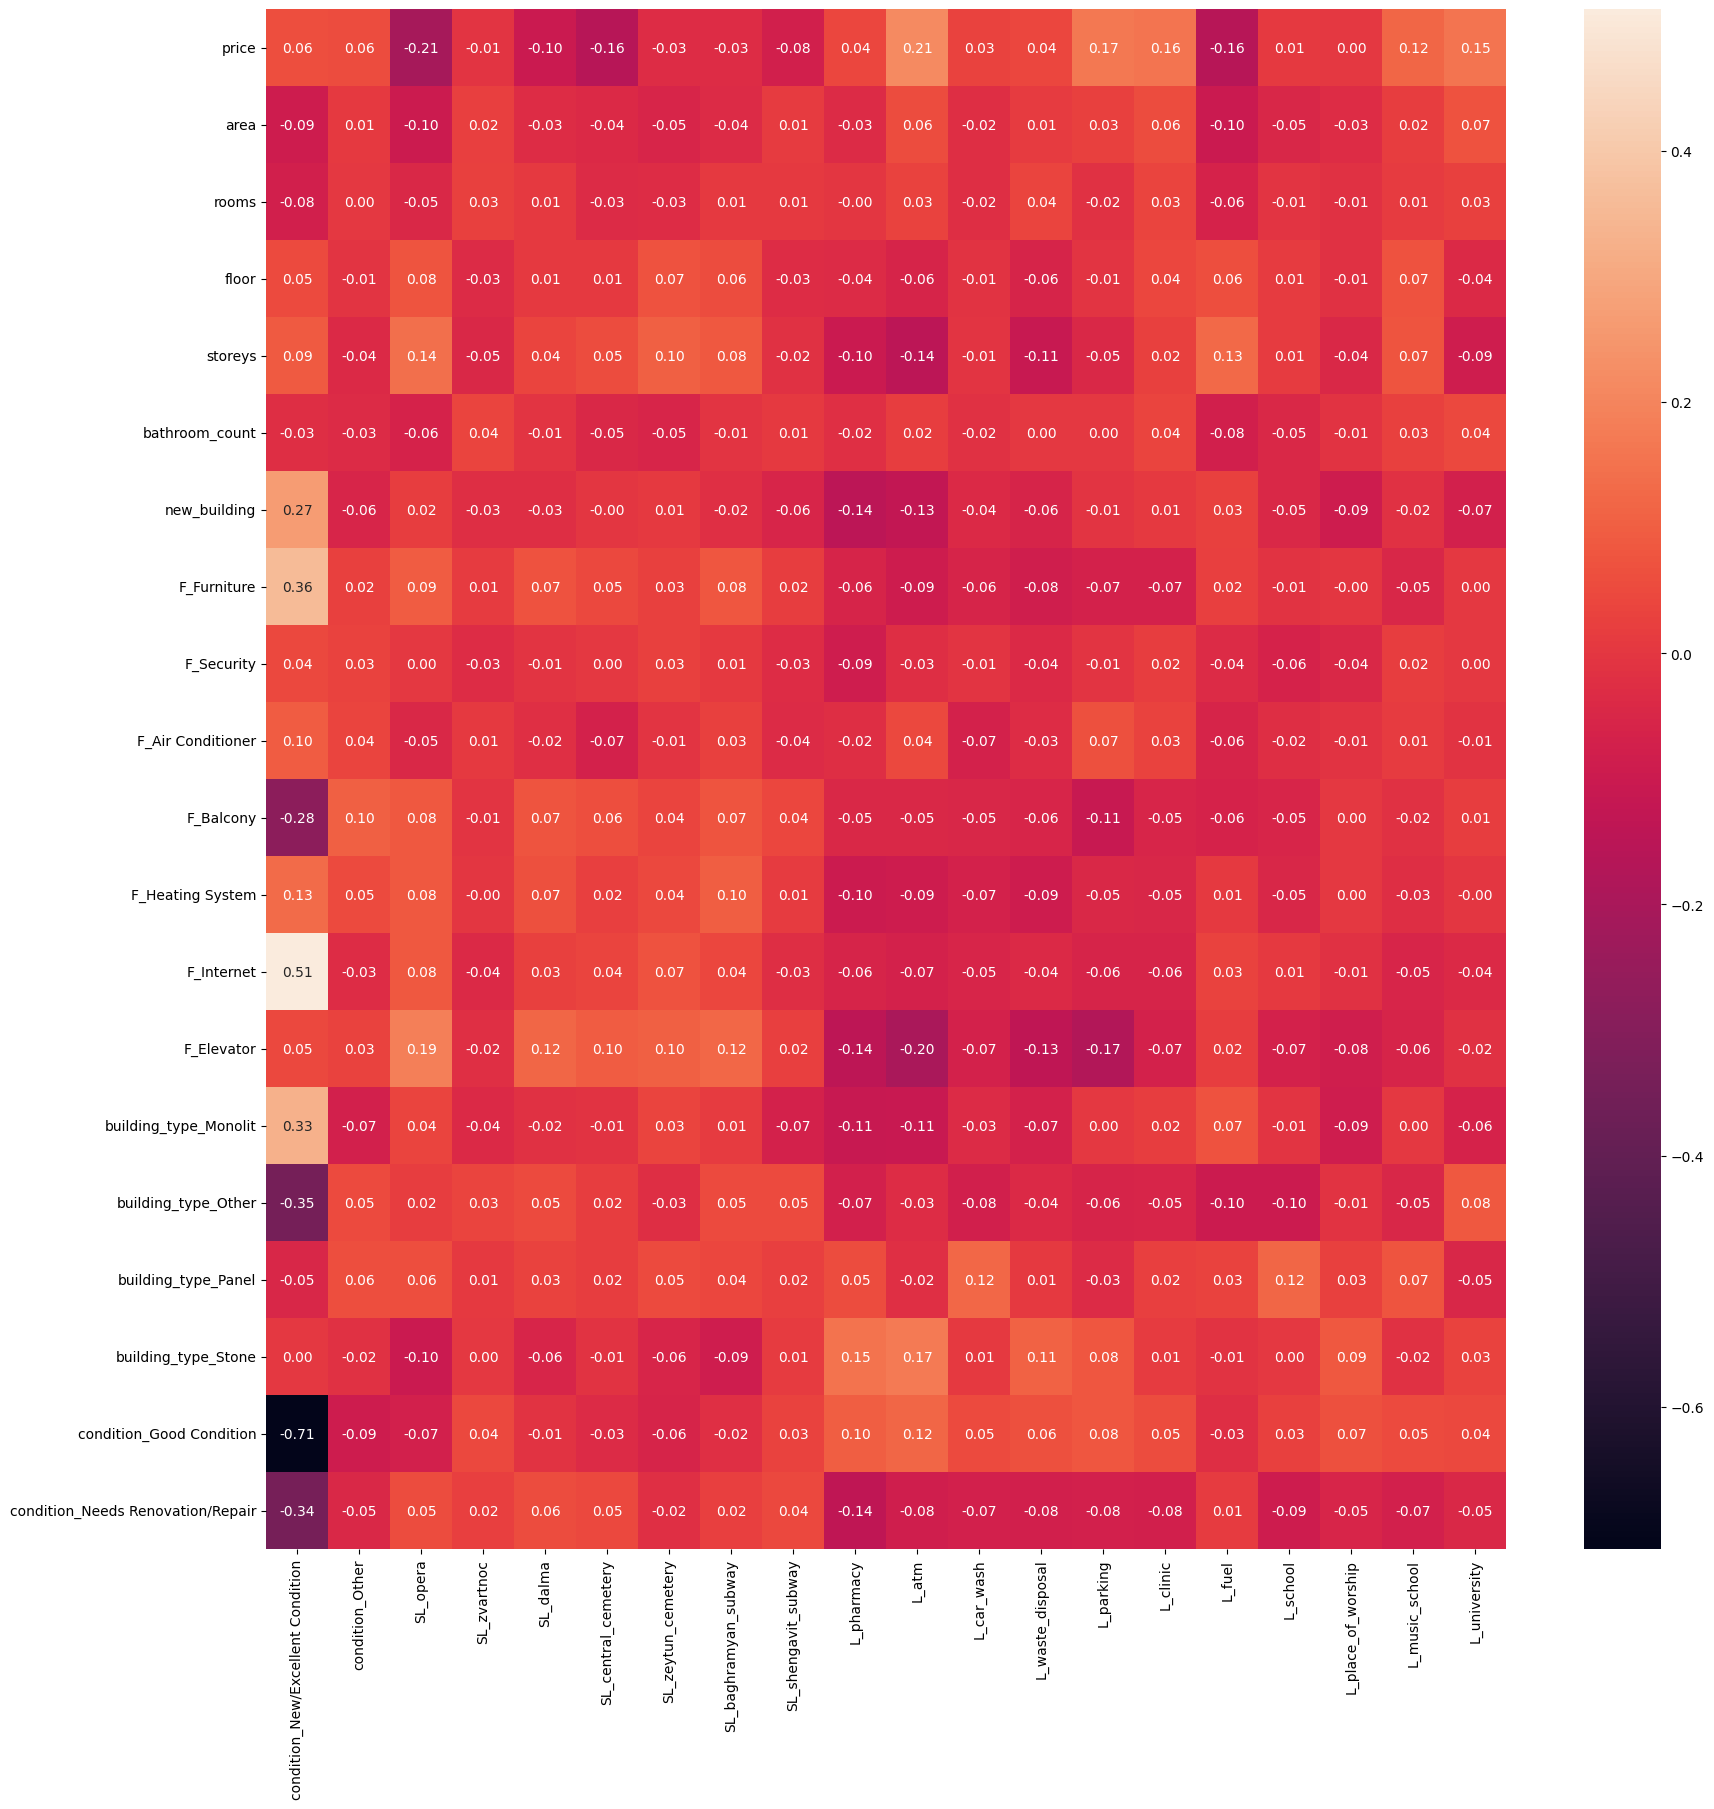

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix.iloc[:20,20:40], annot=True, fmt=".2f")
plt.show()


In [54]:
# Need to remove one of the categorical variables for each encoding
data = data.drop(columns = ["building_type_Other", "condition_Other"])

# Also, removing these features
data = data.drop(columns = ["L_prison", "L_stripclub", "L_bus_station", "SL_zeytun_cemetery", "SL_dalma",
                            "L_car_wash", "L_school", "L_waste_disposal", "L_music_school", "L_fuel"])

In [60]:
# data = pd.read_csv("../processed_data/data.csv")
# data = data.drop(columns = ["SL_barekamutyun_subway", "SL_gergin_subway", 
#                      "SL_sasunci_subway", "SL_yeritasardakan_subway", 
#                             "SL_avan", "SL_charbakh_subway",
#                             "SL_gorcarain_subway", 'latitude', 'longitude',
#                             'SL_yerablur', 'SL_malibu', "SL_massiv", 'SL_yerevan_mall',
#                             "SL_aua", "SL_avan_cemetery", "SL_nork_cemetery",
#                             "SL_zoravar_subway", "SL_davtashen_cemetery",
#                             "SL_shumyan_cemetery",
                            
#                             "L_bank", "L_payment_terminal"
#                            ])
data.info()
data.to_csv("../processed_data/data.csv", index_col=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   source                             2020 non-null   object 
 1   id                                 2020 non-null   object 
 2   price                              2020 non-null   float64
 3   area                               2020 non-null   float64
 4   rooms                              2020 non-null   float64
 5   floor                              2020 non-null   float64
 6   storeys                            2020 non-null   float64
 7   bathroom_count                     2020 non-null   float64
 8   new_building                       2020 non-null   int64  
 9   F_Furniture                        2020 non-null   int64  
 10  F_Security                         2020 non-null   int64  
 11  F_Air Conditioner                  2020 non-null   int64

TypeError: to_csv() got an unexpected keyword argument 'index_col'

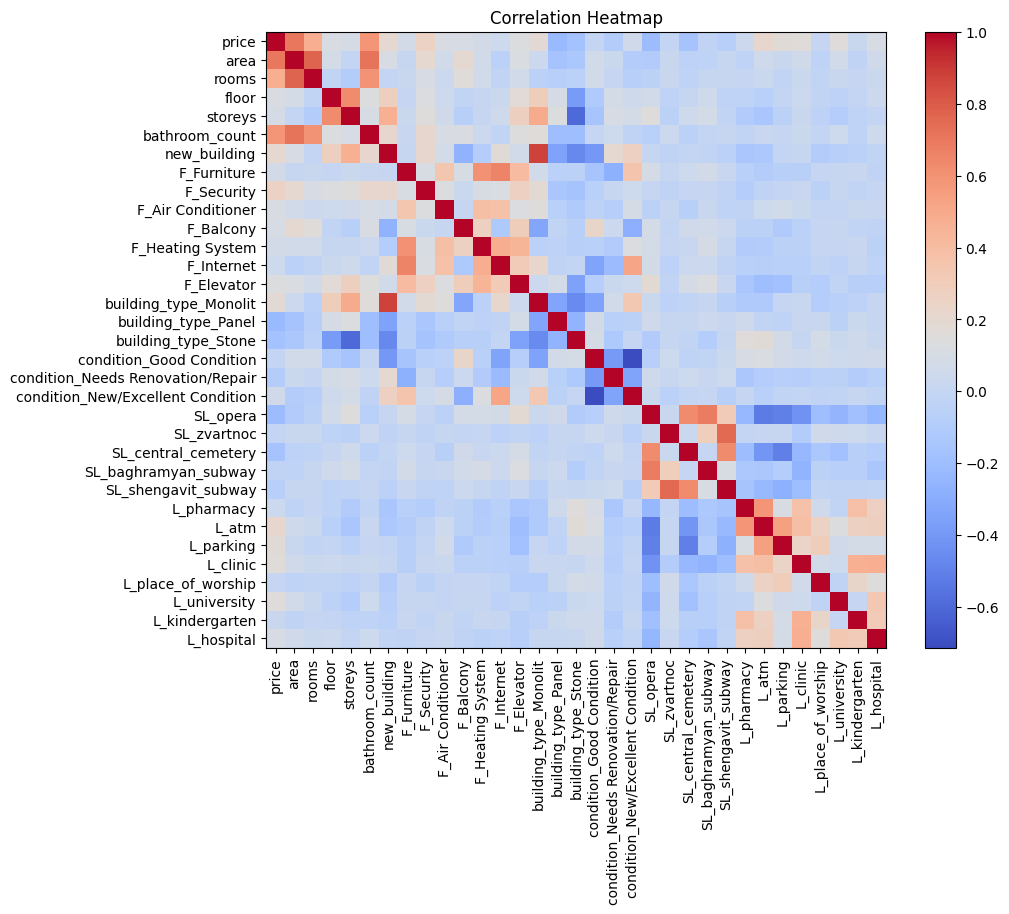

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Create a heatmap to visualize the correlations
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation='vertical')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Heatmap')
plt.show()

# Optionally, you can save the correlation matrix to a new DataFrame
correlation_df = pd.DataFrame(correlation_matrix, columns=data.columns, index=data.columns)


In [57]:
# Flatten the correlation matrix and reset index
correlation_flat = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)).stack().reset_index()
correlation_flat.columns = ['Feature1', 'Feature2', 'Correlation']

# Sort by absolute correlation values in descending order
correlation_flat['AbsCorrelation'] = correlation_flat['Correlation'].abs()
sorted_correlations = correlation_flat.sort_values(by='AbsCorrelation', ascending=False)

# Select top 10 correlated pairs
top_10_correlated_pairs = sorted_correlations.head(60)
top_10_correlated_pairs = top_10_correlated_pairs.drop('AbsCorrelation', axis=1)

print(top_10_correlated_pairs)


                              Feature1                           Feature2  \
184                       new_building              building_type_Monolit   
32                                area                              rooms   
464                        SL_zvartnoc                SL_shengavit_subway   
35                                area                     bathroom_count   
409           condition_Good Condition  condition_New/Excellent Condition   
0                                price                               area   
452                           SL_opera               SL_baghramyan_subway   
207                        F_Furniture                         F_Internet   
474                SL_central_cemetery                SL_shengavit_subway   
93                               floor                            storeys   
451                           SL_opera                SL_central_cemetery   
206                        F_Furniture                   F_Heating System   

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
import numpy as np

# Preparing the data for modeling
# Dropping non-numeric and the target variable 'price'
X = data.select_dtypes(include=np.number).drop('price', axis=1)
y = data['price']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor for feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_feature_importances = rf.feature_importances_

# XGBoost Regressor for feature importance
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
xgb_feature_importances = xgb.feature_importances_

# Recursive Feature Elimination with Random Forest
rfe = RFE(estimator=RandomForestRegressor(n_estimators=50, random_state=42), n_features_to_select=10)
rfe.fit(X_train, y_train)
rfe_support = rfe.support_
rfe_ranking = rfe.ranking_

# Preparing data to return
feature_names = X.columns
rf_importances = pd.Series(rf_feature_importances, index=feature_names).sort_values(ascending=False)
xgb_importances = pd.Series(xgb_feature_importances, index=feature_names).sort_values(ascending=False)
rfe_selected_features = feature_names[rfe_support]

# Evaluating model performance
rf_mse = mean_squared_error(y_test, rf.predict(X_test))
xgb_mse = mean_squared_error(y_test, xgb.predict(X_test))

(rf_importances, xgb_importances, rfe_selected_features)


(area                                 0.550873
 SL_opera                             0.071850
 storeys                              0.062453
 floor                                0.033168
 SL_zvartnoc                          0.031468
 bathroom_count                       0.027052
 SL_baghramyan_subway                 0.024723
 SL_shengavit_subway                  0.023445
 SL_central_cemetery                  0.020263
 L_parking                            0.020025
 condition_New/Excellent Condition    0.013377
 L_atm                                0.012409
 building_type_Monolit                0.010533
 L_pharmacy                           0.009663
 F_Security                           0.008758
 rooms                                0.008664
 F_Elevator                           0.006929
 condition_Needs Renovation/Repair    0.006121
 new_building                         0.005947
 building_type_Panel                  0.005830
 F_Air Conditioner                    0.005407
 condition_Go

In [50]:
correlation_df.price

source                                    NaN
id                                        NaN
price                                1.000000
area                                 0.699985
rooms                                0.472502
floor                                0.115737
storeys                              0.092334
bathroom_count                       0.588964
new_building                         0.196476
F_Furniture                          0.080009
F_Security                           0.256297
F_Air Conditioner                    0.116069
F_Balcony                            0.101491
F_Heating System                     0.077342
F_Internet                           0.045232
F_Elevator                           0.136046
building_type_Monolit                0.183573
building_type_Panel                 -0.224048
building_type_Stone                 -0.166163
condition_Good Condition            -0.004569
condition_Needs Renovation/Repair   -0.090748
condition_New/Excellent Condition 

In [58]:
from scipy import stats

# Assuming 'data' is your DataFrame
z_scores = np.abs(stats.zscore(data["price"] / data["area"]))
outliers_z = np.where(z_scores > 4)

# Print outlier data points
print(data.iloc[outliers_z])
outlier = [
    "myrealty   142500",
    "bnakaran  d116260" #divide by 400
]


        source       id      price   area  rooms  floor  storeys  \
142       bars   1-S-72  1500000.0  170.0    3.0   10.0      5.0   
146       bars   1-S-73  2400000.0  200.0    4.0    9.0      4.0   
530   myrealty   142696  1900000.0  200.0    4.0    5.0     10.0   
588   myrealty   142500  2181820.0   86.0    3.0    4.0      6.0   
1591  bnakaran  d116260   575000.0   66.0    2.0    5.0     10.0   
1711  bnakaran   d94169  1300000.0  150.0    4.0    6.0     10.0   
2018  bnakaran  d103147  2600000.0  280.0    3.0    8.0     10.0   

      bathroom_count  new_building  F_Furniture  ...  L_fuel  L_school  \
142              3.0             0            1  ...       0         1   
146              2.0             0            1  ...       0         1   
530              2.0             1            0  ...       0         3   
588              1.0             1            1  ...       0         0   
1591             1.0             1            0  ...       2         0   
1711       

In [59]:
index = data[(data.source == "bnakaran") & (data.id == "d116260")].index
data.loc[index, 'price'] /= 400

data = data.drop(data[data.id == "142500"].index)

In [69]:
data = data.drop(data[data["area"] > 100000].index)

In [71]:
# data.to_csv("../processed_data/data.csv", index=False)

In [70]:
data

,source,id,price,area,rooms,floor,storeys,bathroom_count,new_building,F_Furniture,...,L_fuel,L_school,L_place_of_worship,L_music_school,L_university,L_kindergarten,L_bus_station,L_hospital,L_prison,L_stripclub
0,bars,4-3-1430,130000.0,60.5,2.0,3.0,13.0,1.0,1,0,...,1,1,0,0,0,0,0,0,0,0
1,bars,4-3-1430.1,215000.0,96.1,3.0,4.0,13.0,2.0,1,0,...,1,1,0,0,0,0,0,0,0,0
2,bars,1-N-432,560000.0,156.4,4.0,9.0,17.0,2.0,0,1,...,1,1,0,0,0,0,0,0,0,0
3,bars,1-N-429,410000.0,75.0,3.0,3.0,12.0,2.0,0,0,...,1,2,1,1,1,1,0,0,0,0
4,bars,1-A-118,420000.0,138.0,4.0,3.0,5.0,2.0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,bnakaran,d117204,315000.0,152.0,5.0,8.0,9.0,2.0,1,0,...,0,0,0,0,0,0,0,2,0,0
2018,bnakaran,d103147,2600000.0,280.0,3.0,8.0,10.0,2.0,1,0,...,0,3,0,0,1,1,0,0,0,0
2019,bnakaran,d117922,150000.0,78.0,2.0,4.0,10.0,1.0,0,0,...,0,1,0,0,0,0,0,3,0,0
2020,bnakaran,d93008,260000.0,90.0,3.0,3.0,5.0,2.0,0,0,...,0,0,0,0,3,0,0,0,0,0
